# HDF5 Files

In [1]:
from datetime import datetime
from glob import glob
import os
import re
import warnings

import geopandas as gpd
import numpy as np
import pandas as pd
import rasterio
import rioxarray as rxr
import xarray as xr

data_path = os.path.join('00a-data', '02-smap-hdf5-xarray')

## Load in study boundary data: Boulder County

In [2]:
boulder_county_path = os.path.join(
    data_path, 
    'boulder-county-boundary', 
    'County_Boundary', 
    'County_Boundary.shp')
boulder_county = gpd.read_file(boulder_county_path)
boulder_county.total_bounds

array([-105.69445188,   39.91297158, -105.05281471,   40.2639591 ])

## Find SMAP files

In [4]:
smap_path_pattern = os.path.join(
    data_path, 'boulder-smap', 'granules', '*', '*.he5')
smap_path_list = glob(smap_path_pattern)
smap_file_df = pd.DataFrame({'path': smap_path_list})
smap_file_df.path[0]

'00a-data/02-smap-hdf5-xarray/boulder-smap/granules/227555905/SMAP_L4_SM_aup_20151116T150000_Vv6032_001_HEGOUT.he5'

In [6]:
smap_path_pattern = (
    "SMAP_L4_SM_aup_(?P<date>\d{8})T(?P<time>\d{6})_Vv6032_001_HEGOUT.he5")
smap_path_re = re.compile(smap_path_pattern)

re.search(smap_path_re, smap_file_df.iloc[0].path).group('date')

'20151116'

In [7]:
def get_datetime_from_filename(filepath, pattern):
    re_match = re.search(pattern, filepath)
    datetime_str = re_match.group('date') + re_match.group('time')
    return datetime.strptime(datetime_str, '%Y%m%d%H%M%S')

In [8]:
smap_file_df['datetime'] = smap_file_df.apply(
    lambda row: get_datetime_from_filename(row.path, smap_path_re), 
    axis=1)
smap_file_df

,path,datetime
0,00a-data/02-smap-hdf5-xarray/boulder-smap/gran...,2015-11-16 15:00:00
1,00a-data/02-smap-hdf5-xarray/boulder-smap/gran...,2016-03-04 18:00:00
2,00a-data/02-smap-hdf5-xarray/boulder-smap/gran...,2015-09-20 21:00:00
3,00a-data/02-smap-hdf5-xarray/boulder-smap/gran...,2015-05-12 00:00:00
4,00a-data/02-smap-hdf5-xarray/boulder-smap/gran...,2016-08-13 03:00:00
...,...,...
4395,00a-data/02-smap-hdf5-xarray/boulder-smap/gran...,2016-04-23 18:00:00
4396,00a-data/02-smap-hdf5-xarray/boulder-smap/gran...,2016-06-15 21:00:00
4397,00a-data/02-smap-hdf5-xarray/boulder-smap/gran...,2015-07-05 03:00:00
4398,00a-data/02-smap-hdf5-xarray/boulder-smap/gran...,2016-08-04 03:00:00


### An object-oriented approach

In [9]:
class DatetimeExtractor:
    """
    Parent class to extract datetimes from filenames
    
    Child classes must define:
      * `re_pattern_str`: the regular expression for the filename
      * `datetime_str`: A function to produce a datetime string from
           a re.Match object
      * `parse_pattern`: the format for the results of `datetime_str`
    """
    
    re_pattern_str = NotImplemented
    parse_pattern = NotImplemented
    
    def __init__(self):
        self.re_pattern = re.compile(self.re_pattern_str)
        
    def match_filename(self, filename):
        """Search the filename for the datetime"""
        return re.search(self.re_pattern, filename)
    
    def from_filename(self, filename):
        """Convert datetime string to DateTime object"""
        datetime_str = self.datetime_str(self.match_filename(filename))
        return datetime.strptime(datetime_str, self.parse_pattern)
    
    def datetime_str(self, match):
        """Produce a datetime string from the Match object"""
        raise NotImplementedError
        
    
class SMAPDatetimeExtractor(DatetimeExtractor):
    """Extract datetimes from SMAP files"""

    re_pattern_str = (
        r'SMAP_L4_SM_aup_'
        '(?P<date>\d{8})T(?P<time>\d{6})'
        '_Vv6032_001_HEGOUT.he5')
    parse_pattern = '%Y%m%d%H%M%S'
    
    def datetime_str(self, match):
        return match.group('date') + match.group('time')

In [82]:
smap_dt_ex = SMAPDatetimeExtractor()
smap_file_df.apply(lambda row: smap_dt_ex.from_filename(row.path), axis=1)

0      2015-11-16 15:00:00
1      2016-03-04 18:00:00
2      2015-09-20 21:00:00
3      2015-05-12 00:00:00
4      2016-08-13 03:00:00
               ...        
4395   2016-04-23 18:00:00
4396   2016-06-15 21:00:00
4397   2015-07-05 03:00:00
4398   2016-08-04 03:00:00
4399   2015-12-19 15:00:00
Length: 4400, dtype: datetime64[ns]

## An example: one file

In [11]:
with rasterio.open(smap_file_df.iloc[0].path) as src:
    subdatasets = src.subdatasets
    sm_surface_ex_path = subdatasets[1]
    lat_path = subdatasets[2]
    lon_path = subdatasets[3]

sm_surface_ex_path, lat_path, lon_path

/Users/elsa/opt/miniconda3/envs/ea-h5py/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


('HDF5:00a-data/02-smap-hdf5-xarray/boulder-smap/granules/227555905/SMAP_L4_SM_aup_20151116T150000_Vv6032_001_HEGOUT.he5://HDFEOS/GRIDS/Analysis_Data/Data_Fields/sm_surface_analysis',
 'HDF5:00a-data/02-smap-hdf5-xarray/boulder-smap/granules/227555905/SMAP_L4_SM_aup_20151116T150000_Vv6032_001_HEGOUT.he5://HDFEOS/GRIDS/FileMainGroup/Data_Fields/cell_lat',
 'HDF5:00a-data/02-smap-hdf5-xarray/boulder-smap/granules/227555905/SMAP_L4_SM_aup_20151116T150000_Vv6032_001_HEGOUT.he5://HDFEOS/GRIDS/FileMainGroup/Data_Fields/cell_lon')

In [12]:
sm_surface_ex_da = rxr.open_rasterio(
    sm_surface_ex_path).squeeze()
sm_surface_ex_da

/Users/elsa/opt/miniconda3/envs/ea-h5py/lib/python3.8/site-packages/rioxarray/_io.py:851: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))  # type: ignore


<xarray.DataArray (y: 4, x: 7)>
array([[0.154197, 0.097038, 0.088493, 0.083183, 0.085167, 0.147728, 0.152977],
       [0.178733, 0.105919, 0.090629, 0.084098, 0.089012, 0.150535, 0.171043],
       [0.182396, 0.106041, 0.092949, 0.083397, 0.081047, 0.097221, 0.101768],
       [0.138145, 0.101463, 0.085045, 0.077476, 0.089622, 0.102592, 0.227195]],
      dtype=float32)
Coordinates:
    band         int64 1
  * x            (x) float64 0.5 1.5 2.5 3.5 4.5 5.5 6.5
  * y            (y) float64 0.5 1.5 2.5 3.5
    spatial_ref  int64 0
Attributes:
    HDFEOS_GRIDS_Analysis_Data_Data_Fields_sm_surface_analysis_coordinates:  ...
    HDFEOS_GRIDS_Analysis_Data_Data_Fields_sm_surface_analysis_DIMENSION_LABE...
    HDFEOS_GRIDS_Analysis_Data_Data_Fields_sm_surface_analysis_fmissing_value...
    HDFEOS_GRIDS_Analysis_Data_Data_Fields_sm_surface_analysis_grid_mapping: ...
    HDFEOS_GRIDS_Analysis_Data_Data_Fields_sm_surface_analysis_long_name:    ...
    HDFEOS_GRIDS_Analysis_Data_Data_Fields_sm_surface_analysis_missing_value:...
    HDFEOS_GRIDS_Analysis_Data_Data_Fields_sm_surface_analysis_pixel_size:   ...
    HDFEOS_GRIDS_Analysis_Data_Data_Fields_sm_surface_analysis_pixel_units:  ...
    HDFEOS_GRIDS_Analysis_Data_Data_Fields_sm_surface_analysis_units:        ...
    HDFEOS_GRIDS_Analysis_Data_Data_Fields_sm_surface_analysis_valid_max:    ...
    HDFEOS_GRIDS_Analysis_Data_Data_Fields_sm_surface_analysis_valid_min:    ...
    HDFEOS_GRIDS_Analysis_Data_Data_Fields_sm_surface_analysis__FillValue:   ...
    _FillValue:                                                              ...
    scale_factor:                                                            ...
    add_offset:                                                              ...

In [13]:
lat_da = rxr.open_rasterio(lat_path).squeeze()
lon_da = rxr.open_rasterio(lon_path).squeeze()
lat_da

/Users/elsa/opt/miniconda3/envs/ea-h5py/lib/python3.8/site-packages/rioxarray/_io.py:851: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))  # type: ignore
/Users/elsa/opt/miniconda3/envs/ea-h5py/lib/python3.8/site-packages/rioxarray/_io.py:851: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))  # type: ignore


<xarray.DataArray (y: 4, x: 7)>
array([[40.17975 , 40.17975 , 40.17975 , 40.17975 , 40.17975 , 40.17975 ,
        40.17975 ],
       [40.087906, 40.087906, 40.087906, 40.087906, 40.087906, 40.087906,
        40.087906],
       [39.99618 , 39.99618 , 39.99618 , 39.99618 , 39.99618 , 39.99618 ,
        39.99618 ],
       [39.90458 , 39.90458 , 39.90458 , 39.90458 , 39.90458 , 39.90458 ,
        39.90458 ]], dtype=float32)
Coordinates:
    band         int64 1
  * x            (x) float64 0.5 1.5 2.5 3.5 4.5 5.5 6.5
  * y            (y) float64 0.5 1.5 2.5 3.5
    spatial_ref  int64 0
Attributes:
    HDFEOS_GRIDS_FileMainGroup_Data_Fields_cell_lat_DIMENSION_LABELS:  YDim XDim
    HDFEOS_GRIDS_FileMainGroup_Data_Fields_cell_lat_fmissing_value:    -9999
    HDFEOS_GRIDS_FileMainGroup_Data_Fields_cell_lat_grid_mapping:      projec...
    HDFEOS_GRIDS_FileMainGroup_Data_Fields_cell_lat_long_name:         The ge...
    HDFEOS_GRIDS_FileMainGroup_Data_Fields_cell_lat_missing_value:     -9999
    HDFEOS_GRIDS_FileMainGroup_Data_Fields_cell_lat_units:             degrees
    HDFEOS_GRIDS_FileMainGroup_Data_Fields_cell_lat_valid_max:         90
    HDFEOS_GRIDS_FileMainGroup_Data_Fields_cell_lat_valid_min:         -90
    HDFEOS_GRIDS_FileMainGroup_Data_Fields_cell_lat__FillValue:        -9999
    _FillValue:                                                        -9999.0
    scale_factor:                                                      1.0
    add_offset:                                                        0.0

In [14]:
sm_surface_ex_da = sm_surface_ex_da.assign_coords(
    {'lat': lat_da, 'lon': lon_da})
sm_surface_ex_da = sm_surface_ex_da.rio.write_crs('EPSG:4326')
sm_surface_ex_da

<xarray.DataArray (y: 4, x: 7)>
array([[0.154197, 0.097038, 0.088493, 0.083183, 0.085167, 0.147728, 0.152977],
       [0.178733, 0.105919, 0.090629, 0.084098, 0.089012, 0.150535, 0.171043],
       [0.182396, 0.106041, 0.092949, 0.083397, 0.081047, 0.097221, 0.101768],
       [0.138145, 0.101463, 0.085045, 0.077476, 0.089622, 0.102592, 0.227195]],
      dtype=float32)
Coordinates:
    band         int64 1
  * x            (x) float64 0.5 1.5 2.5 3.5 4.5 5.5 6.5
  * y            (y) float64 0.5 1.5 2.5 3.5
    lat          (y, x) float32 40.18 40.18 40.18 40.18 ... 39.9 39.9 39.9 39.9
    lon          (y, x) float32 -105.6 -105.5 -105.5 ... -105.3 -105.2 -105.1
    spatial_ref  int64 0
Attributes:
    HDFEOS_GRIDS_Analysis_Data_Data_Fields_sm_surface_analysis_coordinates:  ...
    HDFEOS_GRIDS_Analysis_Data_Data_Fields_sm_surface_analysis_DIMENSION_LABE...
    HDFEOS_GRIDS_Analysis_Data_Data_Fields_sm_surface_analysis_fmissing_value...
    HDFEOS_GRIDS_Analysis_Data_Data_Fields_sm_surface_analysis_grid_mapping: ...
    HDFEOS_GRIDS_Analysis_Data_Data_Fields_sm_surface_analysis_long_name:    ...
    HDFEOS_GRIDS_Analysis_Data_Data_Fields_sm_surface_analysis_missing_value:...
    HDFEOS_GRIDS_Analysis_Data_Data_Fields_sm_surface_analysis_pixel_size:   ...
    HDFEOS_GRIDS_Analysis_Data_Data_Fields_sm_surface_analysis_pixel_units:  ...
    HDFEOS_GRIDS_Analysis_Data_Data_Fields_sm_surface_analysis_units:        ...
    HDFEOS_GRIDS_Analysis_Data_Data_Fields_sm_surface_analysis_valid_max:    ...
    HDFEOS_GRIDS_Analysis_Data_Data_Fields_sm_surface_analysis_valid_min:    ...
    HDFEOS_GRIDS_Analysis_Data_Data_Fields_sm_surface_analysis__FillValue:   ...
    _FillValue:                                                              ...
    scale_factor:                                                            ...
    add_offset:                                                              ...

Ok, now we have a single DataArray. Let's check if clipping works.

In [15]:
sm_surface_ex_da = (
    sm_surface_ex_da
    .stack(z=['x', 'y'])
    .set_index(z=['lon', 'lat'])
    .unstack()
    .rio.set_spatial_dims('lon', 'lat')
    .assign_coords(
        datetime=datetime.strptime('20151116150000', '%Y%m%d%H%M%S'))
)
sm_surface_ex_da

<xarray.DataArray (lon: 7, lat: 4)>
array([[0.1381451 , 0.18239559, 0.17873348, 0.15419735],
       [0.10146298, 0.10604061, 0.10591854, 0.09703793],
       [0.08504452, 0.09294857, 0.09062923, 0.088493  ],
       [0.07747616, 0.08339657, 0.08409847, 0.08318295],
       [0.08962215, 0.08104672, 0.0890118 , 0.08516659],
       [0.10259213, 0.09722103, 0.15053524, 0.14772762],
       [0.2271954 , 0.10176815, 0.17104305, 0.15297665]], dtype=float32)
Coordinates:
    band         int64 1
    spatial_ref  int64 0
  * lon          (lon) float64 -105.6 -105.5 -105.5 -105.4 -105.3 -105.2 -105.1
  * lat          (lat) float64 39.9 40.0 40.09 40.18
    datetime     datetime64[ns] 2015-11-16T15:00:00
Attributes:
    HDFEOS_GRIDS_Analysis_Data_Data_Fields_sm_surface_analysis_coordinates:  ...
    HDFEOS_GRIDS_Analysis_Data_Data_Fields_sm_surface_analysis_DIMENSION_LABE...
    HDFEOS_GRIDS_Analysis_Data_Data_Fields_sm_surface_analysis_fmissing_value...
    HDFEOS_GRIDS_Analysis_Data_Data_Fields_sm_surface_analysis_grid_mapping: ...
    HDFEOS_GRIDS_Analysis_Data_Data_Fields_sm_surface_analysis_long_name:    ...
    HDFEOS_GRIDS_Analysis_Data_Data_Fields_sm_surface_analysis_missing_value:...
    HDFEOS_GRIDS_Analysis_Data_Data_Fields_sm_surface_analysis_pixel_size:   ...
    HDFEOS_GRIDS_Analysis_Data_Data_Fields_sm_surface_analysis_pixel_units:  ...
    HDFEOS_GRIDS_Analysis_Data_Data_Fields_sm_surface_analysis_units:        ...
    HDFEOS_GRIDS_Analysis_Data_Data_Fields_sm_surface_analysis_valid_max:    ...
    HDFEOS_GRIDS_Analysis_Data_Data_Fields_sm_surface_analysis_valid_min:    ...
    HDFEOS_GRIDS_Analysis_Data_Data_Fields_sm_surface_analysis__FillValue:   ...
    _FillValue:                                                              ...
    scale_factor:                                                            ...
    add_offset:                                                              ...

## Modularize the workflow

In [16]:
def get_subdataset_path(dataset_path, varname):
    """
    Get the extended subdataset path for a variable name
    
    Parameters
    ----------
    dataset_path: pathlike
      Path to an HDF5 dataset
    varname: str
      Name of the subdataset to extract
      
    Returns
    -------
    subdataset_path: pathlike
      Path to subdataset
    """
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        with rasterio.open(dataset_path) as src:
            subdataset_paths = src.subdatasets
            # Find the matching subdataset
            subdataset_path = [
                path 
                for path in subdataset_paths 
                if re.search(varname, path)][0]
    return subdataset_path

In [17]:
smap_file_df['sm_surface_path'] = smap_file_df.path.apply(
    get_subdataset_path, varname='sm_surface')
smap_file_df

,path,datetime,sm_surface_path
0,00a-data/02-smap-hdf5-xarray/boulder-smap/gran...,2015-11-16 15:00:00,HDF5:00a-data/02-smap-hdf5-xarray/boulder-smap...
1,00a-data/02-smap-hdf5-xarray/boulder-smap/gran...,2016-03-04 18:00:00,HDF5:00a-data/02-smap-hdf5-xarray/boulder-smap...
2,00a-data/02-smap-hdf5-xarray/boulder-smap/gran...,2015-09-20 21:00:00,HDF5:00a-data/02-smap-hdf5-xarray/boulder-smap...
3,00a-data/02-smap-hdf5-xarray/boulder-smap/gran...,2015-05-12 00:00:00,HDF5:00a-data/02-smap-hdf5-xarray/boulder-smap...
4,00a-data/02-smap-hdf5-xarray/boulder-smap/gran...,2016-08-13 03:00:00,HDF5:00a-data/02-smap-hdf5-xarray/boulder-smap...
...,...,...,...
4395,00a-data/02-smap-hdf5-xarray/boulder-smap/gran...,2016-04-23 18:00:00,HDF5:00a-data/02-smap-hdf5-xarray/boulder-smap...
4396,00a-data/02-smap-hdf5-xarray/boulder-smap/gran...,2016-06-15 21:00:00,HDF5:00a-data/02-smap-hdf5-xarray/boulder-smap...
4397,00a-data/02-smap-hdf5-xarray/boulder-smap/gran...,2015-07-05 03:00:00,HDF5:00a-data/02-smap-hdf5-xarray/boulder-smap...
4398,00a-data/02-smap-hdf5-xarray/boulder-smap/gran...,2016-08-04 03:00:00,HDF5:00a-data/02-smap-hdf5-xarray/boulder-smap...


In [71]:
def open_smap_da(
        subdataset_path, datetime, 
        lat_da, lon_da, boundary_gdf, crs='EPSG:4326'):
    """
    Open SMAP data with lon/lat coordinates and clip
    
    Parameters
    ----------
    subdataset_path: str
      Path to SMAP subdataset from rioxarray
    lat_da: xr.DataArray
      Latitude values
    lon_da: xr.DataArray
      Longitude values
    boundary_gdf: gpd.GeoDataFrame
      Boundary to clip to
    crs: str
      (optional) CRS to use for SMAP data; defaults to lat/lon
        
    Returns
    -------
    subdataset_da: xr.DataArray
      Clipped and georeferenced data
    """
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        subdataset_da = (
            # Open data
            rxr.open_rasterio(subdataset_path, masked=True)
            .squeeze()
            # Switch coordinates to lon/lat from x/y
            .assign_coords({'lat': lat_da, 'lon': lon_da})
            .rio.write_crs(crs)
            .stack(z=['x', 'y'])
            .set_index(z=['lon', 'lat'])
            .unstack()
            .rio.set_spatial_dims('lon', 'lat')
            # Clip to study boundary
            .rio.clip(boundary_gdf.geometry, boundary_gdf.crs)
            # Add datetime
            .assign_coords(datetime=datetime)
        )
    return subdataset_da

### for loops vs. pd.DataFrame.apply: similar performance in this case

In [72]:
smap_file_subset_df = smap_file_df.loc[:10,:].copy()

In [73]:
%%time
smap_da_list = []
for i, row in smap_file_subset_df.iterrows():
    smap_da_list.append(
        open_smap_da(row.sm_surface_path, row.datetime, 
                     lat_da, lon_da, boulder_county))

CPU times: user 407 ms, sys: 52.8 ms, total: 460 ms
Wall time: 512 ms


In [74]:
smap_da_list[0]

<xarray.DataArray (lon: 7, lat: 3)>
array([[0.18239559,        nan, 0.15419735],
       [0.10604061, 0.10591854, 0.09703793],
       [0.09294857, 0.09062923, 0.088493  ],
       [0.08339657, 0.08409847, 0.08318295],
       [0.08104672, 0.0890118 , 0.08516659],
       [0.09722103, 0.15053524, 0.14772762],
       [0.10176815, 0.17104305, 0.15297665]], dtype=float32)
Coordinates:
  * lon          (lon) float64 -105.6 -105.5 -105.5 -105.4 -105.3 -105.2 -105.1
  * lat          (lat) float64 40.0 40.09 40.18
    band         int64 1
    spatial_ref  int64 0
    datetime     datetime64[ns] 2015-11-16T15:00:00
Attributes:
    HDFEOS_GRIDS_Analysis_Data_Data_Fields_sm_surface_analysis_coordinates:  ...
    HDFEOS_GRIDS_Analysis_Data_Data_Fields_sm_surface_analysis_DIMENSION_LABE...
    HDFEOS_GRIDS_Analysis_Data_Data_Fields_sm_surface_analysis_fmissing_value...
    HDFEOS_GRIDS_Analysis_Data_Data_Fields_sm_surface_analysis_grid_mapping: ...
    HDFEOS_GRIDS_Analysis_Data_Data_Fields_sm_surface_analysis_long_name:    ...
    HDFEOS_GRIDS_Analysis_Data_Data_Fields_sm_surface_analysis_missing_value:...
    HDFEOS_GRIDS_Analysis_Data_Data_Fields_sm_surface_analysis_pixel_size:   ...
    HDFEOS_GRIDS_Analysis_Data_Data_Fields_sm_surface_analysis_pixel_units:  ...
    HDFEOS_GRIDS_Analysis_Data_Data_Fields_sm_surface_analysis_units:        ...
    HDFEOS_GRIDS_Analysis_Data_Data_Fields_sm_surface_analysis_valid_max:    ...
    HDFEOS_GRIDS_Analysis_Data_Data_Fields_sm_surface_analysis_valid_min:    ...
    HDFEOS_GRIDS_Analysis_Data_Data_Fields_sm_surface_analysis__FillValue:   ...
    scale_factor:                                                            ...
    add_offset:                                                              ...

In [75]:
%%time
smap_file_subset_df['DataArray'] = smap_file_subset_df.apply(
    lambda row: open_smap_da(
        row.sm_surface_path, row.datetime, lat_da, lon_da, boulder_county),
    axis=1)
smap_file_subset_df

CPU times: user 376 ms, sys: 25.4 ms, total: 402 ms
Wall time: 401 ms


,path,datetime,sm_surface_path,DataArray
0,00a-data/02-smap-hdf5-xarray/boulder-smap/gran...,2015-11-16 15:00:00,HDF5:00a-data/02-smap-hdf5-xarray/boulder-smap...,"[[<xarray.DataArray ()>\narray(0.18239559, dty..."
1,00a-data/02-smap-hdf5-xarray/boulder-smap/gran...,2016-03-04 18:00:00,HDF5:00a-data/02-smap-hdf5-xarray/boulder-smap...,"[[<xarray.DataArray ()>\narray(0.17715274, dty..."
2,00a-data/02-smap-hdf5-xarray/boulder-smap/gran...,2015-09-20 21:00:00,HDF5:00a-data/02-smap-hdf5-xarray/boulder-smap...,"[[<xarray.DataArray ()>\narray(0.10324915, dty..."
3,00a-data/02-smap-hdf5-xarray/boulder-smap/gran...,2015-05-12 00:00:00,HDF5:00a-data/02-smap-hdf5-xarray/boulder-smap...,"[[<xarray.DataArray ()>\narray(0.338435, dtype..."
4,00a-data/02-smap-hdf5-xarray/boulder-smap/gran...,2016-08-13 03:00:00,HDF5:00a-data/02-smap-hdf5-xarray/boulder-smap...,"[[<xarray.DataArray ()>\narray(0.16566268, dty..."
5,00a-data/02-smap-hdf5-xarray/boulder-smap/gran...,2016-06-13 15:00:00,HDF5:00a-data/02-smap-hdf5-xarray/boulder-smap...,"[[<xarray.DataArray ()>\narray(0.37384045, dty..."
6,00a-data/02-smap-hdf5-xarray/boulder-smap/gran...,2015-06-26 18:00:00,HDF5:00a-data/02-smap-hdf5-xarray/boulder-smap...,"[[<xarray.DataArray ()>\narray(0.24010101, dty..."
7,00a-data/02-smap-hdf5-xarray/boulder-smap/gran...,2016-02-28 00:00:00,HDF5:00a-data/02-smap-hdf5-xarray/boulder-smap...,"[[<xarray.DataArray ()>\narray(0.17566156, dty..."
8,00a-data/02-smap-hdf5-xarray/boulder-smap/gran...,2015-11-29 18:00:00,HDF5:00a-data/02-smap-hdf5-xarray/boulder-smap...,"[[<xarray.DataArray ()>\narray(0.17149715, dty..."
9,00a-data/02-smap-hdf5-xarray/boulder-smap/gran...,2016-08-25 12:00:00,HDF5:00a-data/02-smap-hdf5-xarray/boulder-smap...,"[[<xarray.DataArray ()>\narray(0.20303056, dty..."


### Concatenate arrays

In [59]:
smap_subset_da = xr.concat(smap_file_subset_df.DataArray, dim='datetime')
smap_subset_da

<xarray.DataArray (datetime: 11, lon: 7, lat: 3)>
array([[[ 1.82395592e-01, -9.99900000e+03,  1.54197350e-01],
        [ 1.06040612e-01,  1.05918542e-01,  9.70379263e-02],
        [ 9.29485708e-02,  9.06292349e-02,  8.84930044e-02],
        [ 8.33965689e-02,  8.40984732e-02,  8.31829458e-02],
        [ 8.10467154e-02,  8.90118033e-02,  8.51665884e-02],
        [ 9.72210318e-02,  1.50535241e-01,  1.47727624e-01],
        [ 1.01768151e-01,  1.71043053e-01,  1.52976647e-01]],

       [[ 1.77152738e-01, -9.99900000e+03,  1.51273832e-01],
        [ 1.17033109e-01,  1.08671293e-01,  9.60370153e-02],
        [ 2.35563383e-01,  2.30924711e-01,  2.01994047e-01],
        [ 1.52982816e-01,  1.34489164e-01,  1.10258207e-01],
        [ 6.53363317e-02,  7.52850622e-02,  7.55597204e-02],
        [ 8.60272497e-02,  1.41019925e-01,  1.38395414e-01],
        [ 9.78680700e-02,  1.73246488e-01,  1.42973050e-01]],

       [[ 1.03249148e-01, -9.99900000e+03,  1.07430056e-01],
        [ 6.82149678e-02,  7.07784444e-02,  7.16634542e-02],
        [ 6.11196309e-02,  6.02956563e-02,  6.02651387e-02],
        [ 5.65419942e-02,  5.79000264e-02,  5.63588887e-02],
...
        [ 8.59563723e-02,  8.53155032e-02,  8.24468508e-02],
        [ 9.89568606e-02,  1.53003499e-01,  1.50134847e-01],
        [ 1.04388990e-01,  1.80042073e-01,  1.58801839e-01]],

       [[ 2.03030556e-01, -9.99900000e+03,  1.92776650e-01],
        [ 1.37845010e-01,  1.35342568e-01,  1.27896279e-01],
        [ 1.26706094e-01,  1.17703408e-01,  1.07876748e-01],
        [ 1.20480508e-01,  1.11111611e-01,  9.98811424e-02],
        [ 1.10196084e-01,  1.00583047e-01,  8.20588768e-02],
        [ 1.17733926e-01,  1.52371377e-01,  1.30703896e-01],
        [ 1.15200967e-01,  1.62075967e-01,  1.23288125e-01]],

       [[ 3.50650609e-01, -9.99900000e+03,  3.49307835e-01],
        [ 3.52969944e-01,  3.51260960e-01,  3.53336155e-01],
        [ 2.69595921e-01,  2.53726780e-01,  2.25101292e-01],
        [ 1.62784398e-01,  1.49356663e-01,  1.33304417e-01],
        [ 1.28909886e-01,  1.30435765e-01,  1.25583470e-01],
        [ 1.51004612e-01,  2.14114964e-01,  2.13931859e-01],
        [ 1.62296116e-01,  2.43594944e-01,  2.25284398e-01]]],
      dtype=float32)
Coordinates:
  * lon          (lon) float64 -105.6 -105.5 -105.5 -105.4 -105.3 -105.2 -105.1
  * lat          (lat) float64 40.0 40.09 40.18
    band         int64 1
    spatial_ref  int64 0
  * datetime     (datetime) datetime64[ns] 2015-11-16T15:00:00 ... 2016-04-28...
Attributes:
    HDFEOS_GRIDS_Analysis_Data_Data_Fields_sm_surface_analysis_coordinates:  ...
    HDFEOS_GRIDS_Analysis_Data_Data_Fields_sm_surface_analysis_DIMENSION_LABE...
    HDFEOS_GRIDS_Analysis_Data_Data_Fields_sm_surface_analysis_fmissing_value...
    HDFEOS_GRIDS_Analysis_Data_Data_Fields_sm_surface_analysis_grid_mapping: ...
    HDFEOS_GRIDS_Analysis_Data_Data_Fields_sm_surface_analysis_long_name:    ...
    HDFEOS_GRIDS_Analysis_Data_Data_Fields_sm_surface_analysis_missing_value:...
    HDFEOS_GRIDS_Analysis_Data_Data_Fields_sm_surface_analysis_pixel_size:   ...
    HDFEOS_GRIDS_Analysis_Data_Data_Fields_sm_surface_analysis_pixel_units:  ...
    HDFEOS_GRIDS_Analysis_Data_Data_Fields_sm_surface_analysis_units:        ...
    HDFEOS_GRIDS_Analysis_Data_Data_Fields_sm_surface_analysis_valid_max:    ...
    HDFEOS_GRIDS_Analysis_Data_Data_Fields_sm_surface_analysis_valid_min:    ...
    HDFEOS_GRIDS_Analysis_Data_Data_Fields_sm_surface_analysis__FillValue:   ...
    scale_factor:                                                            ...
    add_offset:                                                              ...
    _FillValue:                                                              ...

### A quick look at the results

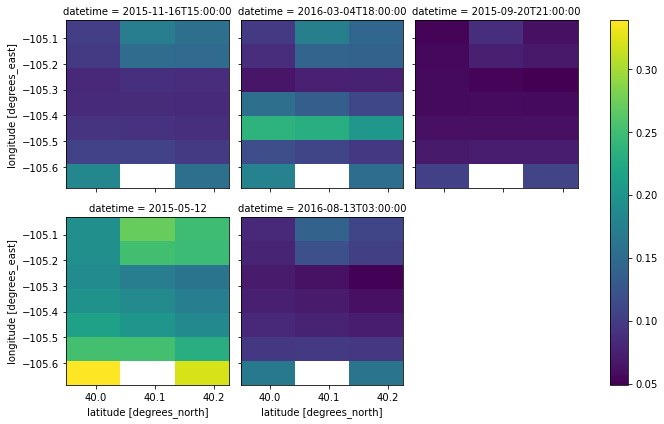

In [77]:
smap_subset_da.isel(datetime=slice(0, 5)).plot(col='datetime', col_wrap=3)

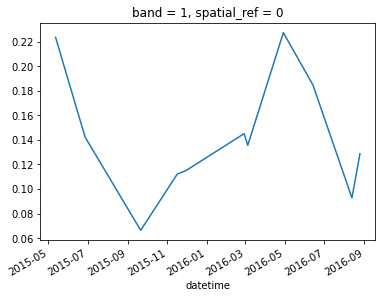

In [81]:
smap_subset_da.mean(dim=['lat', 'lon']).sortby('datetime').plot()

In [ ]:
!./bin/02-smap-hdf5-xarray-to-html.sh